In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

In [2]:
path_data = r'C:\Users\user\siemens_hack_2022\0_data'

path_data_Hamelin = os.path.join(path_data, 'Hamelin_drive')

In [3]:
os.listdir(path_data_Hamelin)

['hamelin_energy.pkl',
 'hamelin_metadata.csv',
 'hamelin_weather.pkl',
 'weather_data.csv']

In [4]:
all_trends_DE = pd.read_csv(os.path.join(path_data, 'all_trends_DE.csv'))
all_trends_DE = all_trends_DE.pivot_table(index='date',columns='title',values='value')
all_trends_DE.index = pd.to_datetime(all_trends_DE.index)

In [5]:
hamelin_weather = pd.read_pickle(os.path.join(path_data_Hamelin, 'hamelin_weather.pkl'))

In [6]:
hamelin_metadata = pd.read_csv(os.path.join(path_data_Hamelin, 'hamelin_metadata.csv'))

In [7]:
hamelin_energy = pd.read_pickle(os.path.join(path_data_Hamelin, 'hamelin_energy.pkl'))

In [8]:
df_holiday = []

for year in np.arange(2017, 2021+1):
    holiday_temp = pd.read_html('https://www.timeanddate.com/holidays/germany/'+str(year)+'?hol=9')[0]
    holiday_temp.columns = holiday_temp.columns.get_level_values(0)
    holiday_temp = holiday_temp[~holiday_temp['Date'].str.contains('Observed').fillna(False)]
    holiday_temp = holiday_temp[holiday_temp['Type'].str.contains('National').fillna(False)]
    holiday_temp = holiday_temp.dropna(how='all')
    holiday_temp = holiday_temp[['Date', 'Name', 'Type']]
    holiday_temp['Date'] = str(year) + ' ' + holiday_temp['Date']
    holiday_temp['Date'] = pd.to_datetime(holiday_temp['Date'])
    
    df_holiday.append(holiday_temp)
    
df_holiday = pd.concat(df_holiday, axis=0, ignore_index=True)

df_holiday = df_holiday.drop_duplicates(subset=['Date'])
df_holiday = df_holiday.set_index('Date').asfreq('D')
df_holiday.loc[df_holiday.index.weekday>=5, 'Name'] = 'weekend'
df_holiday.loc[df_holiday.index.weekday>=5, 'Type'] = 'weekend'
df_holiday['Name'] = df_holiday['Name'].fillna('weekday')
df_holiday['Type'] = df_holiday['Type'].fillna('weekday')
df_holiday.columns = 'holiday_' + df_holiday.columns

df_holiday = df_holiday.reset_index()
df_holiday = df_holiday.rename(columns={'Date':'date'}) 

In [9]:
df_holiday_encode = df_holiday.copy()
df_holiday_encode[['holiday_Name', 'holiday_Type']] = df_holiday_encode[['holiday_Name', 'holiday_Type']].astype('str').apply(preprocessing.LabelEncoder().fit_transform)
df_holiday_encode.columns = df_holiday_encode.columns+'_encode'
df_holiday_encode = df_holiday_encode.rename(columns={'date_encode':'date'})

In [10]:
HOME_mean =  hamelin_energy.loc[:, hamelin_energy.columns.str.contains('HOME')].mean(axis=1)
TOT_mean =  hamelin_energy.loc[:, hamelin_energy.columns.str.contains('TOT')].mean(axis=1)
HEAT_mean =  hamelin_energy.loc[:, hamelin_energy.columns.str.contains('HEAT')].mean(axis=1)
substation_mean =  hamelin_energy.loc[:, hamelin_energy.columns.str.contains('substation')].mean(axis=1)

### HOME

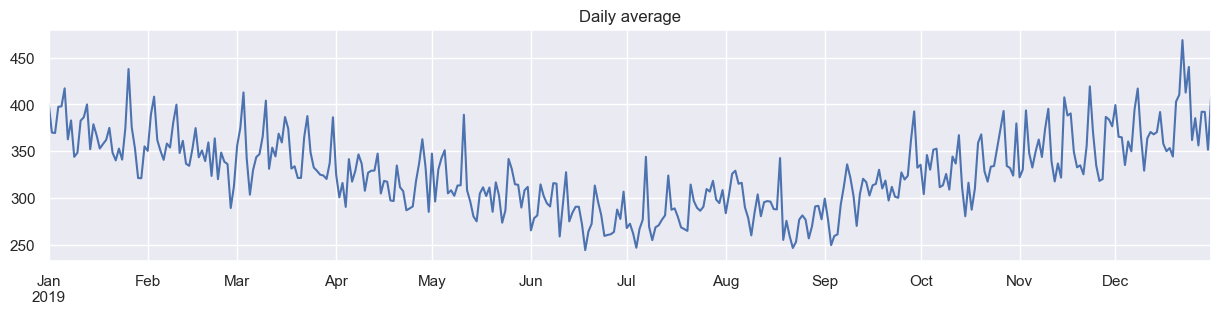

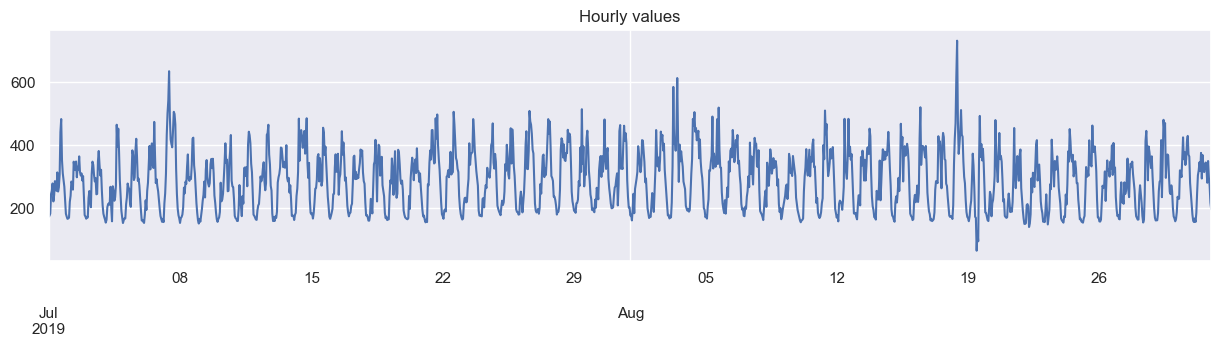

In [11]:
HOME_mean.loc['2019'].resample('D').mean().plot(title='Daily average', figsize=(15,3))
plt.show()
HOME_mean.loc['2019-07':'2019-08'].plot(title='Hourly values', figsize=(15,3))
plt.show()

In [12]:
df_dataset = HOME_mean.rename('load').to_frame().copy()


index_temp = df_dataset.index.copy()

df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset['load_shift24'] = df_dataset['load'].shift(24)
df_dataset['load_shift168'] = df_dataset['load'].shift(168)

df_dataset = df_dataset.merge(hamelin_weather['WEATHER_T'], left_index=True, right_index=True)
df_dataset['WEATHER_T_roll24_mean'] = df_dataset['WEATHER_T'].rolling(24).mean()

df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.merge(df_holiday_encode, on='date')
df_dataset = df_dataset.merge(all_trends_DE.reset_index(), on='date')
#df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp


df_dataset

load       date  year  weekday  hour  timeofweek  \
2018-05-18 01:00:00  183.358877 2018-05-18  2018        4   1.0        97.0   
2018-05-18 02:00:00  168.608142 2018-05-18  2018        4   2.0        98.0   
2018-05-18 03:00:00  212.435030 2018-05-18  2018        4   3.0        99.0   
2018-05-18 04:00:00  366.932407 2018-05-18  2018        4   4.0       100.0   
2018-05-18 05:00:00  456.314655 2018-05-18  2018        4   5.0       101.0   
...                         ...        ...   ...      ...   ...         ...   
2020-12-31 19:00:00  459.419851 2020-12-31  2020        3  19.0        91.0   
2020-12-31 20:00:00  366.613639 2020-12-31  2020        3  20.0        92.0   
2020-12-31 21:00:00  382.776537 2020-12-31  2020        3  21.0        93.0   
2020-12-31 22:00:00  343.477349 2020-12-31  2020        3  22.0        94.0   
2020-12-31 23:00:00  309.179676 2020-12-31  2020        3  23.0        95.0   

                     load_shift24  load_shift168  WEATHER_T  \
2018-05-18 01:00:00           NaN            NaN  10.200000   
2018-05-18 02:00:00           NaN            NaN   9.900000   
2018-05-18 03:00:00           NaN            NaN   9.400000   
2018-05-18 04:00:00           NaN            NaN   9.100000   
2018-05-18 05:00:00           NaN            NaN   8.700000   
...                           ...            ...        ...   
2020-12-31 19:00:00    537.941561     447.137546   1.883333   
2020-12-31 20:00:00    389.495375     366.149137   1.816667   
2020-12-31 21:00:00    351.260483     329.952042   1.550000   
2020-12-31 22:00:00    302.292196     334.764004   1.266667   
2020-12-31 23:00:00    215.738754     303.509996   1.200000   

                     WEATHER_T_roll24_mean  ... The Office Twelfth Grade  \
2018-05-18 01:00:00                    NaN  ...   0.694603      2.448987   
2018-05-18 02:00:00                    NaN  ...   0.694603      2.448987   
2018-05-18 03:00:00                    NaN  ...   0.694603      2.448987   
2018-05-18 04:00:00                    NaN  ...   0.694603      2.448987   
2018-05-18 05:00:00                    NaN  ...   0.694603      2.448987   
...                                    ...  ...        ...           ...   
2020-12-31 19:00:00               2.717361  ...  -0.205865     -0.540932   
2020-12-31 20:00:00               2.649306  ...  -0.205865     -0.540932   
2020-12-31 21:00:00               2.582986  ...  -0.205865     -0.540932   
2020-12-31 22:00:00               2.509375  ...  -0.205865     -0.540932   
2020-12-31 23:00:00               2.417014  ...  -0.205865     -0.540932   

                     United States Postal Service  User Account  Windows 10  \
2018-05-18 01:00:00                      0.122252     -1.098366    0.264958   
2018-05-18 02:00:00                      0.122252     -1.098366    0.264958   
2018-05-18 03:00:00                      0.122252     -1.098366    0.264958   
2018-05-18 04:00:00                      0.122252     -1.098366    0.264958   
2018-05-18 05:00:00                      0.122252     -1.098366    0.264958   
...                                           ...           ...         ...   
2020-12-31 19:00:00                      0.559656      0.038202   -1.376967   
2020-12-31 20:00:00                      0.559656      0.038202   -1.376967   
2020-12-31 21:00:00                      0.559656      0.038202   -1.376967   
2020-12-31 22:00:00                      0.559656      0.038202   -1.376967   
2020-12-31 23:00:00                      0.559656      0.038202   -1.376967   

                      Writing   Xfinity     macOS        new  school holiday  
2018-05-18 01:00:00  1.227456 -0.687932 -0.902781  -0.119594       -0.509444  
2018-05-18 02:00:00  1.227456 -0.687932 -0.902781  -0.119594       -0.509444  
2018-05-18 03:00:00  1.227456 -0.687932 -0.902781  -0.119594       -0.509444  
2018-05-18 04:00:00  1.227456 -0.687932 -0.902781  -0.119594       -0.509444  
2018-05-18 05:00:00  1.227456 -0.687932 -0.902781  -0.119594    

## 1st model: temporal feature + weather feature

C:\Users\user\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<AxesSubplot: xlabel='timeofweek', ylabel='load'>

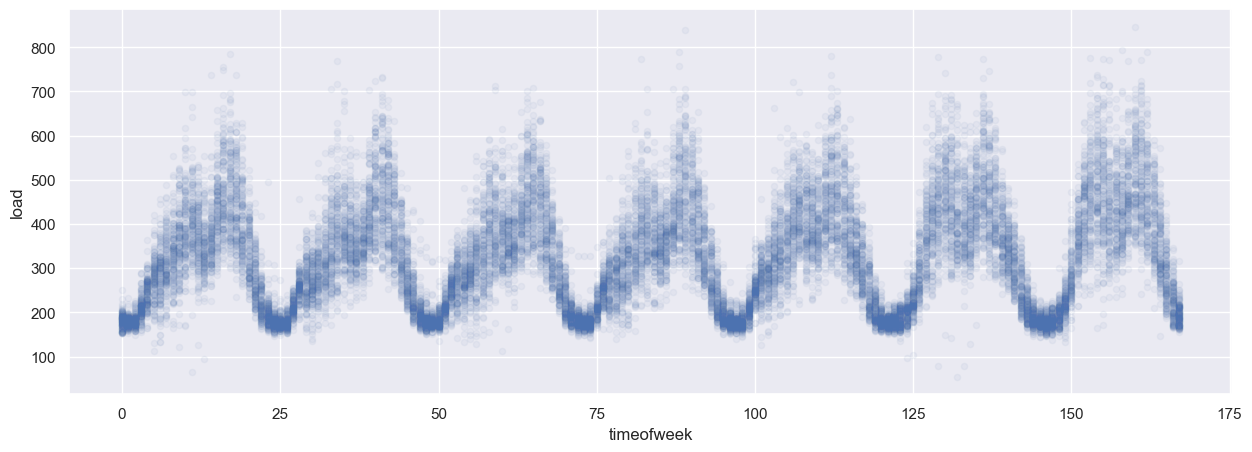

In [13]:
df_dataset.plot(kind='scatter',x='timeofweek',y='load', figsize=(15,5),alpha=0.05)

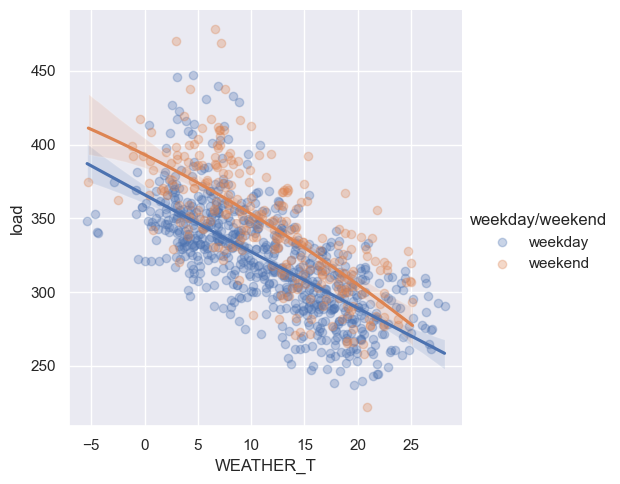

In [14]:
# Scatter plot for demand and outdoor temperature
df_plot = df_dataset.resample('D').mean().copy()
df_plot['weekday/weekend'] = 'weekday'
df_plot.loc[df_plot['weekday']>4, 'weekday/weekend'] ='weekend'

sns.lmplot(x='WEATHER_T', y='load', hue="weekday/weekend",
           data=df_plot, order=2, scatter_kws={'alpha':0.3})

In [15]:
list_feat = ['weekday','hour','WEATHER_T', 'WEATHER_T_roll24_mean']

Model: LGBM
R SQUARED: 0.7393
MAE: 42.4454


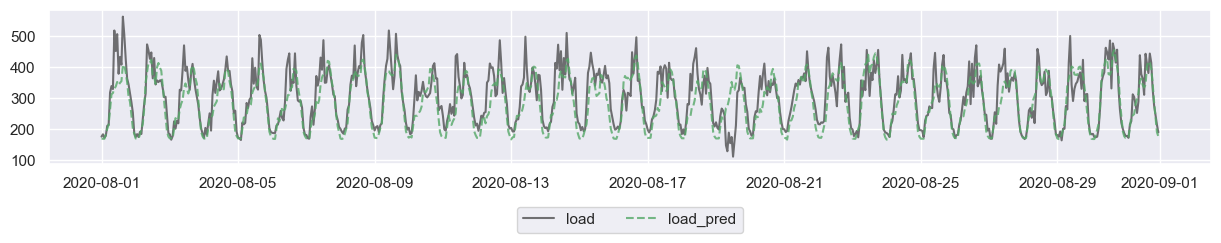

In [16]:
traindata = df_dataset.loc[:'2019'].copy()
testdata = df_dataset.loc['2020':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

In [17]:
testdata[['load','load_pred']].iplot()
(testdata['load_pred'] - testdata['load']).resample('D').mean().iplot(kind='bar')

## 2nd model: add calendar data

In [18]:
list_feat = ['weekday','hour','WEATHER_T', 'WEATHER_T_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode']

Model: LGBM
R SQUARED: 0.7394
MAE: 42.3567


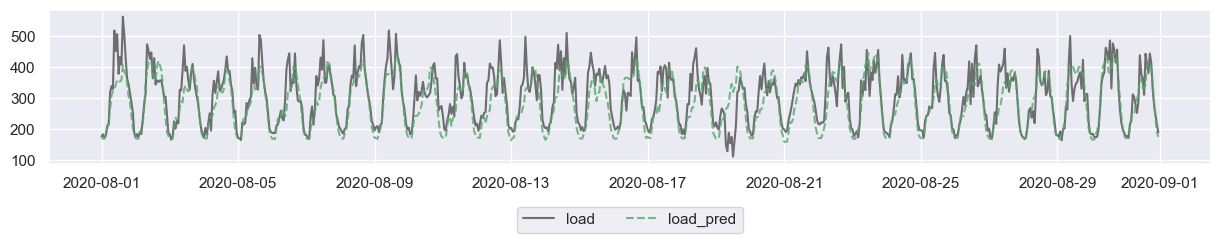

In [19]:
traindata = df_dataset.loc[:'2019'].copy()
testdata = df_dataset.loc['2020':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

In [20]:
testdata[['load','load_pred']].iplot()
(testdata['load_pred'] - testdata['load']).resample('D').mean().iplot(kind='bar')

## 3rd model: add lag features

In [21]:
list_feat = ['weekday','hour','WEATHER_T', 'WEATHER_T_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode',
             'load_shift24', 'load_shift168']

Model: LGBM
R SQUARED: 0.7803
MAE: 38.5879


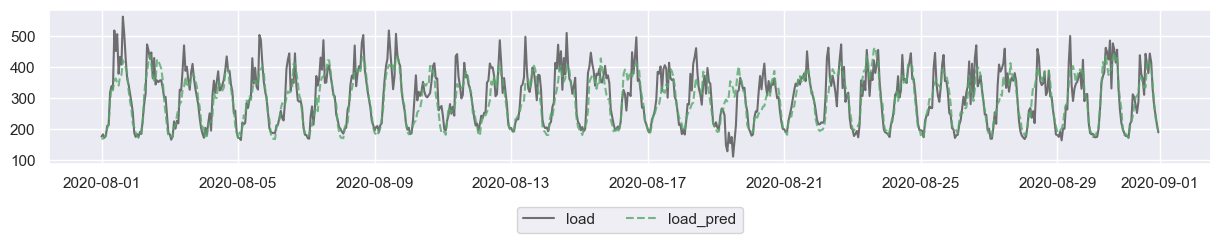

In [22]:
traindata = df_dataset.loc[:'2019'].copy()
testdata = df_dataset.loc['2020':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

In [23]:
testdata[['load','load_pred']].iplot()
(testdata['load_pred'] - testdata['load']).resample('D').mean().iplot(kind='bar')

## 4rd model: add google trends data

In [24]:
df_plot = df_dataset.resample('D').mean()
df_plot = (df_plot-df_plot.mean())/df_plot.std()
df_plot[['load','Microsoft Excel', 'Education', 'WEATHER_T']].iplot()

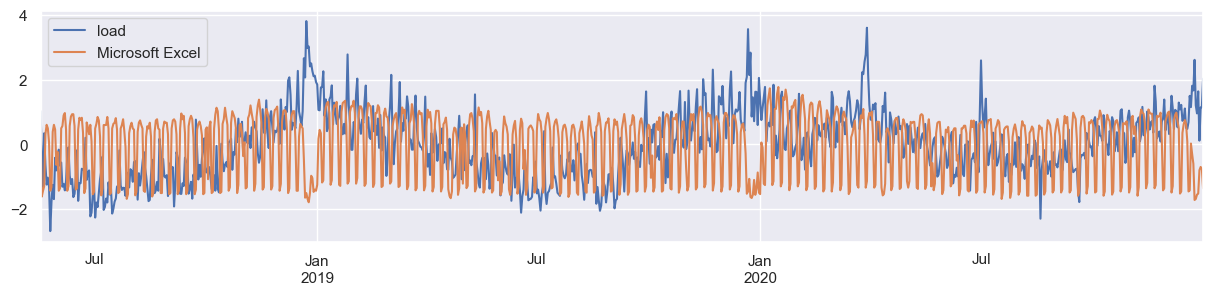

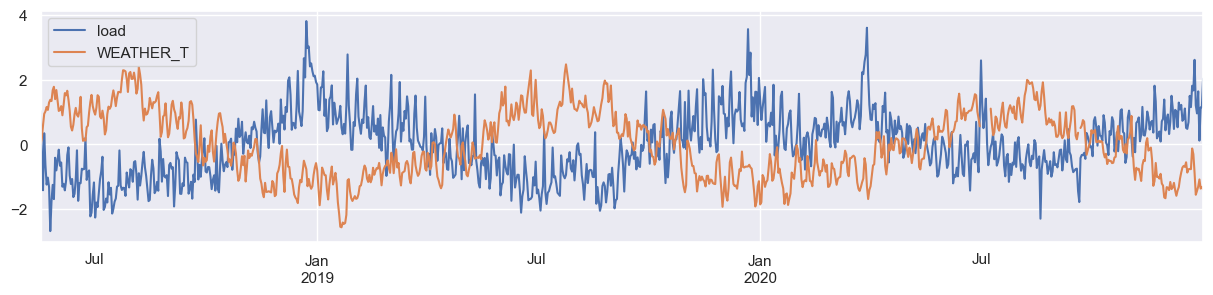

In [25]:
df_plot = df_dataset.resample('D').mean()
df_plot = (df_plot-df_plot.mean())/df_plot.std()
df_plot[['load','Microsoft Excel']].loc[:'2020'].plot(figsize=(15,3))
plt.show()
df_plot[['load','WEATHER_T']].loc[:'2020'].plot(figsize=(15,3))
plt.show()

In [26]:
list_feat = ['weekday','hour','WEATHER_T', 'WEATHER_T_roll24_mean',
             'holiday_Name_encode','holiday_Type_encode',
             'load_shift24', 'load_shift168',
             'Microsoft Excel', 'Education']

Model: LGBM
R SQUARED: 0.7855
MAE: 38.3374


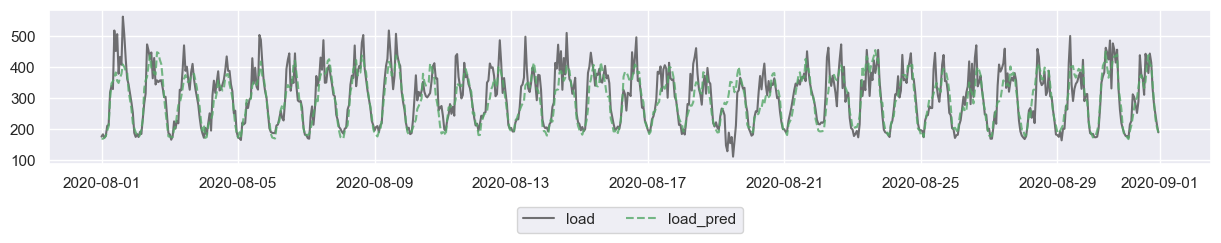

In [27]:
traindata = df_dataset.loc[:'2019'].copy()
testdata = df_dataset.loc['2020':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load'])
testdata['load_pred'] = LGB_model.predict(testdata[list_feat])
errors = abs(testdata['load_pred'] - testdata['load'])
RSQUARED = r2_score(testdata['load'], testdata['load_pred'])
MAE = mean_absolute_error(testdata['load'], testdata['load_pred'])

print("Model: LGBM")
print("R SQUARED: "+str(round(RSQUARED,4)))
print("MAE: "+str(round(MAE,4)))

plt.figure(figsize=(15,2))
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load'], '-k', alpha=0.6, label='load')
plt.plot(testdata.loc['2020-8'].index, testdata.loc['2020-8','load_pred'], '--g', alpha=0.8, label='load_pred')
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.5))

In [28]:
testdata[['load','load_pred']].iplot()
(testdata['load_pred'] - testdata['load']).resample('D').mean().iplot(kind='bar')